<a href="https://colab.research.google.com/github/mz-zarei/CGAN-Augmentation/blob/main/CGAN_data_augmentation_WA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libs**

In [1]:
import warnings
warnings.filterwarnings('ignore')

from utils import nb_model, metrics, CGAN
from utils.crash import simulateCrashData
from utils.feature_selection import forward_regression, backward_regression

import importlib
import random
import seaborn as sns
sns.set_style("darkgrid")

import pandas as pd

from matplotlib import pyplot

import numpy as np
from numpy import expand_dims, zeros, ones, vstack
from numpy.random import randn, randint

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.distributions.empirical_distribution import ECDF

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# **Preparing Crash Data**

In [3]:
## Importing Data
y_name = 'FI'
Path_to_data = "./Data/UrbanFreeWay4laneDivided.xlsx"

all_data = pd.read_excel(Path_to_data)
print(f'Columns: {all_data.columns}')
all_data.sort_values(by=['ID'])

# data['TERRAIN'].describe()
# all_data.groupby('year').FI.describe().round(2)

Columns: Index(['RURURB', 'TERRAIN', 'LSHLDWID', 'LSHL_WD2', 'MEDWID', 'NO_LANES',
       'RSHLDWID', 'RSHL_WD2', 'SEG_LNG', 'lanewid', 'AADT', 'year', 'RSW_r',
       'LSW_r', 'Divided', 'rodwycls', 'Class', 'Class2', 'ID', 'PDO', 'Fatal',
       'Injury', 'FI', 'TotalCrash'],
      dtype='object')


,RURURB,TERRAIN,LSHLDWID,LSHL_WD2,MEDWID,NO_LANES,RSHLDWID,RSHL_WD2,SEG_LNG,lanewid,...,Divided,rodwycls,Class,Class2,ID,PDO,Fatal,Injury,FI,TotalCrash
0,U,L,0,4,750,4,0,8,0.02,23,...,d,1,UM,UM_d,002_0.14_0.16,0,0,0,0,0
9255,U,L,0,4,750,4,0,8,0.02,23,...,d,1,UM,UM_d,002_0.14_0.16,0,0,0,0,0
6170,U,L,0,4,750,4,0,8,0.02,23,...,d,1,UM,UM_d,002_0.14_0.16,0,0,0,0,0
15425,U,L,0,4,750,4,0,8,0.02,23,...,d,1,UM,UM_d,002_0.14_0.16,1,0,0,0,1
3085,U,L,0,4,750,4,0,8,0.02,23,...,d,1,UM,UM_d,002_0.14_0.16,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15422,U,R,0,0,18,4,0,0,0.07,19,...,d,1,UM,UM_d,705_1.43_1.5,1,0,2,2,3
9252,U,R,0,0,18,4,0,0,0.07,19,...,d,1,UM,UM_d,705_1.43_1.5,0,0,1,1,1
12337,U,R,0,0,18,4,0,0,0.07,19,...,d,1,UM,UM_d,705_1.43_1.5,1,0,0,0,1
3082,U,R,0,0,18,4,0,0,0.07,19,...,d,1,UM,UM_d,705_1.43_1.5,1,0,0,0,1


In [7]:
# Keep data for the last two years
data = all_data[all_data["year"] > 2015].copy()
data = data.sample(frac=1).reset_index(drop=True)

# Feature transformations
data['log_AADT'] = np.log(data["AADT"])
data['SEG_LNG'] = data['SEG_LNG']   * 1609                        # mile to m
data['MEDWID'] = data['MEDWID']     * 0.3048                      # ft to m
data['RSHLDWID'] = data['RSHLDWID'] * 0.3048                      # ft to m
data['LSHLDWID'] = data['LSHLDWID'] * 0.3048                      # ft to m

data['log_L'] = np.log(data['SEG_LNG'])
data['MED_dummy'] = [1 if m > 3 else 0 for m in data.MEDWID.values]
data['LSW_dummy'] = [1 if m > 0 else 0 for m in data.LSHLDWID.values]
data['RSW_dummy'] = [1 if m > 0 else 0 for m in data.RSHLDWID.values]

# Terrain_one_hot = pd.get_dummies(data.TERRAIN, prefix='TERRAIN')
# data[Terrain_one_hot.columns.to_list()] = Terrain_one_hot


# Split train and test data sets

test_ids = random.sample(set(data['ID'].unique()), 585)
train_data_all = data.loc[~data['ID'].isin(test_ids)].copy()
test_data = data.loc[data['ID'].isin(test_ids)].copy().reset_index(drop=True)

test_data = pd.read_excel('test_data.xlsx')

data[['MEDWID','RSHLDWID','AADT', 'SEG_LNG', 'FI']].describe().round(2)

,MEDWID,RSHLDWID,AADT,SEG_LNG,FI
count,6170.00,6170.00,6170.00,6170.00,6170.00
mean,12.21,2.61,49001.51,134.75,0.29
std,12.68,1.08,28412.41,190.94,0.91
min,0.61,0.00,5082.00,16.09,0.00
25%,4.88,3.05,27385.00,32.18,0.00
50%,12.19,3.05,45875.00,64.36,0.00
75%,14.63,3.05,64507.00,160.90,0.00
max,228.60,7.32,178149.00,3250.18,23.00


# **Fit NB model (Truth)**

In [26]:
x_features = ['MED_dummy','RSW_dummy','log_AADT', 'log_L']
significant_features = nb_model.backward_regression(data, x_features, 
                                            y_name=y_name, threshold_out=0.05, 
                                            verbose=False)
NB_model_true, alpha_true  = nb_model.fitNB(data, significant_features, y_name=y_name)
test_pred_true = NB_model_true.predict(sm.add_constant(test_data[significant_features]))
test_data['True-SPF'] = test_pred_true

all_pred_true = NB_model_true.predict(sm.add_constant(data[significant_features]))
data['True-SPF'] = all_pred_true


print(f"Dispersion: {alpha_true:0.2f}")
print(NB_model_true.summary2())

Dispersion: 1.02
               Results: Generalized linear model
Model:              GLM              AIC:            6533.2916  
Link Function:      log              BIC:            -50785.8234
Dependent Variable: FI               Log-Likelihood: -3261.6    
Date:               2022-09-20 18:39 LL-Null:        -4197.1    
No. Observations:   6170             Deviance:       3018.9     
Df Model:           4                Pearson chi2:   6.23e+03   
Df Residuals:       6165             Scale:          1.0000     
Method:             IRLS                                        
----------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
----------------------------------------------------------------
const        -19.8920   0.7111 -27.9752 0.0000 -21.2856 -18.4983
MED_dummy     -0.5572   0.1198  -4.6512 0.0000  -0.7920  -0.3224
RSW_dummy     -0.6440   0.0953  -6.7564 0.0000  -0.8309  -0.4572
log_AADT       1.4081   

# **Train CGAN and Fit NB models on Augmented/non-Augmented Data**

In [ ]:
# Sample From Train Data
sample_size = 1000
x_features = ['MED_dummy','RSW_dummy','log_AADT', 'log_L']

train_ids = random.sample(set(train_data_all['ID'].unique()), sample_size)
train_data = train_data_all.loc[train_data_all['ID'].isin(train_ids)].copy().reset_index(drop=True)

# train_data.to_excel('train_data.xlsx')
# train_data = pd.read_excel('train_data.xlsx')

train_pred_true = NB_model_true.predict(sm.add_constant(train_data[significant_features]))
train_data['True-SPF'] = train_pred_true

# display(train_data.describe().round(3))
train_data[x_features + ['FI']].hist(bins = 15, figsize=(7, 5))
train_data.FI.mean()

In [23]:
# Fit NB on non-Augmented Sample
x_features = ['MED_dummy','RSW_dummy','log_AADT', 'log_L']
significant_features = nb_model.backward_regression(train_data, x_features, 
                                                y_name=y_name, threshold_out=0.05, 
                                                verbose=False)
# significant_features = x_features                                  
NB_model, alpha  = nb_model.fitNB(train_data, significant_features, y_name=y_name)

test_pred_nonAugmented = NB_model.predict(sm.add_constant(test_data[significant_features]))
test_data['Base-SPF'] = test_pred_nonAugmented
all_pred_nonAugmented = NB_model.predict(sm.add_constant(data[significant_features]))
data['Base-SPF'] = all_pred_nonAugmented
train_pred_nonAugmented = NB_model.predict(sm.add_constant(train_data[significant_features]))
train_data['Base-SPF'] = train_pred_nonAugmented


# Evaluation
## predictive metrics on test set
mae_non_augmented  = mean_absolute_error(test_pred_true, test_pred_nonAugmented)
mape_non_augmented = nb_model.MAPE(test_pred_true.values, test_pred_nonAugmented.values)
rmse_non_augmented  = mean_squared_error(test_pred_true, test_pred_nonAugmented)**0.5
## accuracy of dispersion
mape_alpha_non_augmented = abs(alpha_true - alpha)/alpha_true

print(f"Dispersion: {alpha:0.3f}, MAPE alpha: {mape_alpha_non_augmented}") 
print(f"MAE: {mae_non_augmented:0.3f}, RMSE: {rmse_non_augmented:0.3f}, MAPE: {mape_non_augmented:0.3f}")
print(NB_model.summary())

Dispersion: 0.582, MAPE alpha: 0.4313434603063516
MAE: 0.046, RMSE: 0.142, MAPE: 0.153
                 Generalized Linear Model Regression Results                  
Dep. Variable:                     FI   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1996
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1053.5
Date:                Tue, 20 Sep 2022   Deviance:                       1037.5
Time:                        18:38:25   Pearson chi2:                 2.24e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

>Accuracy real: 30%, fake: 59%
Epoch: 100, dLoss real = 0.698, dLoss fake = 0.703, gLoss = 0.695


>Accuracy real: 47%, fake: 51%
Epoch: 200, dLoss real = 0.700, dLoss fake = 0.702, gLoss = 0.691


>Accuracy real: 57%, fake: 42%
Epoch: 300, dLoss real = 0.690, dLoss fake = 0.699, gLoss = 0.693


>Accuracy real: 78%, fake: 43%
Epoch: 400, dLoss real = 0.692, dLoss fake = 0.698, gLoss = 0.696


>Accuracy real: 28%, fake: 65%
Epoch: 500, dLoss real = 0.693, dLoss fake = 0.693, gLoss = 0.696


>Accuracy real: 32%, fake: 74%
Epoch: 600, dLoss real = 0.694, dLoss fake = 0.695, gLoss = 0.694


>Accuracy real: 61%, fake: 50%
Epoch: 700, dLoss real = 0.693, dLoss fake = 0.695, gLoss = 0.695


>Accuracy real: 39%, fake: 68%
Epoch: 800, dLoss real = 0.694, dLoss fake = 0.694, gLoss = 0.694


>Accuracy real: 56%, fake: 31%
Epoch: 900, dLoss real = 0.692, dLoss fake = 0.696, gLoss = 0.695


>Accuracy real: 31%, fake: 78%
Epoch: 1000, dLoss real = 0.699, dLoss fake = 0.691, gLoss = 0.700


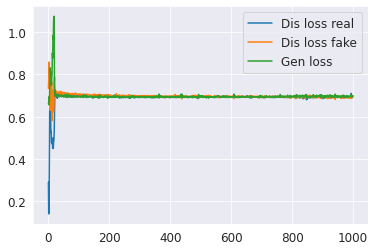

In [30]:
gen_lr, dis_lr, n_epochs, n_batch = 0.0002, 0.0002, 1000, int(100) 
save_path = './models/'

# train data
x_train = train_data[x_features].copy()
y_train = train_data[y_name].copy()

# create a CGAN class
cgan = CGAN(latent_dim=1, x_size=4, in_shape = 1, seed=42, activation='elu')
# create the discriminator
d_model = cgan.define_discriminator(dis_lr)
# create the generator
g_model = cgan.define_generator()
# create the gan
gan_model = cgan.define_gan(g_model, d_model, gen_lr)
# load data
dataset = cgan.load_real_samples(x_train,y_train)

# train model
d1_hist, d2_hist, g_hist = cgan.train(g_model, d_model, gan_model, dataset, n_epochs, n_batch, save_path)

In [55]:
# load GAN model
model_path = './models/'
model = load_model(model_path + 'gen_e800.h5')

# train data
x_train = train_data[x_features].copy()
y_train = train_data[y_name].copy()
dataset = cgan.load_real_samples(x_train, y_train)
# find empirical distribution for crash count
n, max = len(dataset[1]), dataset[1].max()+1
prob = np.array([1/n if np.count_nonzero(dataset[1]==i)==0 else np.count_nonzero(dataset[1]==i)/n for i in range(max)])
prob /= sum(prob)  # fixing prob sum to be 1

# generate latent points
latent_points = cgan.generate_latent_points(2000, dataset)
# generate samples
Fake_data = model.predict(latent_points)
fake = pd.DataFrame(Fake_data, columns=x_features)
fake[y_name] = latent_points[1]
fake['MED_dummy'] =  [1 if m > 0.5 else 0 for m in fake.MED_dummy.values]
fake['RSW_dummy'] =  [1 if m > 0.5 else 0 for m in fake.RSW_dummy.values]


## NB model with real and fake data
# Find significant features
concat_data = pd.concat([train_data, fake])
x_train_augmented = concat_data[x_features]
y_train_augmented = concat_data[y_name]
significant_features = nb_model.forward_regression(concat_data, x_features, y_name=y_name, threshold_in=0.05, verbose=False) 
# significant_features = x_features
NB_model_augmented, alpha_augmented = nb_model.fitNB(concat_data, significant_features, y_name=y_name)

test_pred_Augmented = NB_model_augmented.predict(sm.add_constant(test_data[significant_features]))
test_data['Augmented-SPF'] = test_pred_Augmented

all_pred_Augmented = NB_model_augmented.predict(sm.add_constant(data[significant_features]))
data['Augmented-SPF'] = all_pred_Augmented

train_pred_Augmented = NB_model_augmented.predict(sm.add_constant(train_data[significant_features]))
train_data['Augmented-SPF'] = train_pred_Augmented

# Evaluation
## predictive metrics on test set
mae_augmented  = mean_absolute_error(test_pred_true, test_pred_Augmented)
mape_augmented = nb_model.MAPE(test_pred_true.values, test_pred_Augmented.values)
rmse_augmented  = mean_squared_error(test_pred_true, test_pred_Augmented)**0.5
## accuracy of dispersion
mape_alpha_augmented = abs(alpha_true - alpha_augmented)/alpha_true

# print(f"Dispersion: {alpha_augmented:0.3f}, MAPE alpha: {mape_alpha_augmented:0.3f}") 
print(f"MAE: {mae_augmented:0.3f}, RMSE: {rmse_augmented:0.3f}, MAPE: {mape_augmented:0.3f}")
print(alpha_augmented, NB_model_augmented.summary())
# print(alpha, NB_model.summary())
# print(alpha_true, NB_model_true.summary())


MAE: 0.093, RMSE: 0.171, MAPE: 0.505
0.8156599196144249                  Generalized Linear Model Regression Results                  
Dep. Variable:                     FI   No. Observations:                 6000
Model:                            GLM   Df Residuals:                     5995
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2959.0
Date:                Tue, 20 Sep 2022   Deviance:                       2556.7
Time:                        19:16:58   Pearson chi2:                 5.72e+03
No. Iterations:                    15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

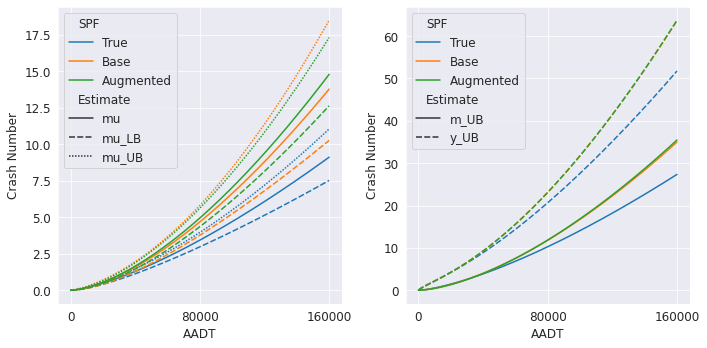

In [99]:
# Compute confidence intervalls
def get_CIs(NB_model, alpha, spf):
    cov = NB_model.cov_params().values
    # prepare input for NB model
    x_arr = []
    for i in range(1,160000, 200):
        point = []
        for var in NB_model.params.keys():
            if var == 'log_AADT':
                point.append(np.log(i))
            elif var == 'log_L':
                point.append(7)
            else:
                point.append(1)
        x_arr.append(point)
    x_arr = np.array(x_arr)

    res = []
    for x in x_arr:
        mu = NB_model.predict(x)[0]
        var_etta = x @ cov @ x.T
        # 95% CI for mu
        mu_LB = mu * np.exp(-1.96 * np.sqrt(var_etta))
        mu_UB = mu * np.exp(1.96 * np.sqrt(var_etta))
        # 95% CI for y
        y_LB = 0
        y_UB =  mu + np.sqrt(19) * np.sqrt( mu + mu**2 * ( alpha*(var_etta+1)+var_etta ) )
        # 95% CI for m
        m_LB = mu - 1.96*np.sqrt( mu**2 * ( alpha*(var_etta+1)+var_etta ) )
        m_LB = 0 if m_LB<0 else m_LB
        m_UB =  mu + 1.96 * np.sqrt( mu**2 * ( alpha*(var_etta+1)+var_etta ) )

        # append to result array
        aadt_ind = list(NB_model.params.keys()).index('log_AADT')
        res.append([np.exp(x[aadt_ind]), mu, 'mu', spf])
        res.append([np.exp(x[aadt_ind]), mu_LB, 'mu_LB', spf])
        res.append([np.exp(x[aadt_ind]), mu_UB, 'mu_UB', spf])
        res.append([np.exp(x[aadt_ind]), m_UB, 'm_UB', spf])
        res.append([np.exp(x[aadt_ind]), y_UB, 'y_UB', spf])

        
    res = pd.DataFrame(res, columns=["AADT", "Crash Number", "Estimate", "SPF"])
    return res


CI_true   = get_CIs(NB_model_true, alpha_true, spf='True')
CI_noaug  = get_CIs(NB_model, alpha, spf='Base')
CI_aug    = get_CIs(NB_model_augmented, 0.5, spf='Augmented')

CI_concat = pd.concat([CI_true, CI_noaug, CI_aug]).reset_index(drop=True)

fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=False)

mu_data = CI_concat[CI_concat.Estimate.isin(['mu', 'mu_UB', 'mu_LB'])].reset_index(drop=True).copy()
m_y_data  = CI_concat[CI_concat.Estimate.isin(['m_UB', 'y_UB'])].reset_index(drop=True).copy()

sns.lineplot(data = mu_data  , x='AADT', y='Crash Number', style='Estimate', hue='SPF', ax=ax[0])
sns.lineplot(data = m_y_data , x='AADT', y='Crash Number', style='Estimate', hue='SPF', ax=ax[1])


ax[0].set_xticks([0, 80000, 160000])
ax[1].set_xticks([0, 80000, 160000])

plt.tight_layout()
fig.savefig('CIs.pdf')

# **Distributions and CURE plots**

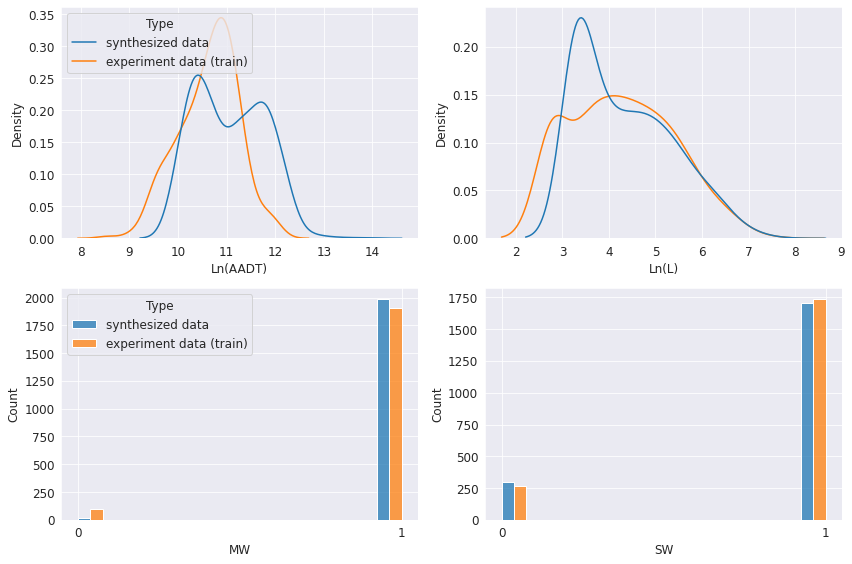

In [108]:
train_data_all['Type'] = 'real data'
train_data['Type'] = 'experiment data (train)'
fake['Type'] = 'synthesized data'

real_all = train_data_all[fake.columns].copy()
real_experiment = train_data[fake.columns].copy()
fake_sample = fake.sample(2000)
concat_data = pd.concat([fake_sample ,real_experiment]).reset_index(drop=True)
concat_data.columns = ['MW', 'SW', 'Ln(AADT)', 'Ln(L)', 'FI', 'Type']

fig, ax = plt.subplots(2,2,figsize=(12,8))

sns.kdeplot(data=concat_data, x="Ln(AADT)" , hue="Type", ax = ax[0,0], bw_adjust = 1.5)
sns.kdeplot(data=concat_data, x="Ln(L)"    , hue="Type", ax = ax[0,1], bw_adjust = 1.5)
sns.histplot(data=concat_data, x="MW"      , hue="Type", ax = ax[1,0], multiple="dodge")
sns.histplot(data=concat_data, x="SW"      , hue="Type", ax = ax[1,1], multiple="dodge")
ax[0,1].get_legend().remove()
ax[1,1].get_legend().remove()
sns.move_legend(ax[0,0], loc='upper left')

ax[1,0].set_xticks([0,1])
ax[1,1].set_xticks([0,1])

plt.tight_layout()
fig.savefig('Distributions.pdf')

0.16666666666666666
0.26837606837606837
0.04871794871794872


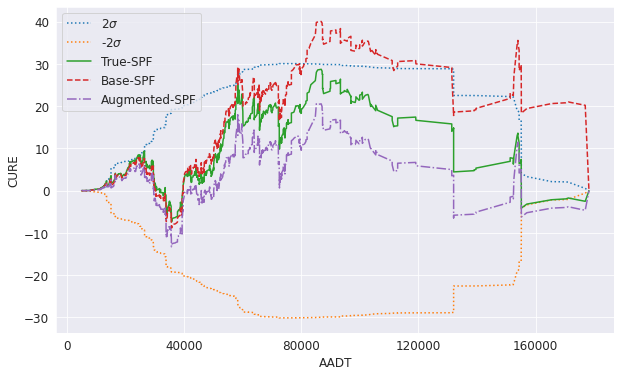

In [107]:
# CURE plot
for df in [test_data]:
    fig, ax = plt.subplots(1, figsize=(10,6)) 
    plt.rcParams.update({'font.size': 12})

    CURE(df=df, ax=ax, plot_label= "True-SPF", x_label='AADT', y_name= 'FI', x='AADT', y_pred = 'True-SPF', boundry=True)
    CURE(df=df, ax=ax, ls='--', plot_label= "Base-SPF", x_label='AADT', y_name= 'FI', x='AADT', y_pred = 'Base-SPF', boundry=False)
    CURE(df=df, ax=ax, ls='-.', plot_label= "Augmented-SPF", x_label='AADT', y_name= 'FI', x='AADT', y_pred = 'Augmented-SPF', boundry=False)

    ax.set_xticks([0,40000,80000, 120000,160000])
    plt.legend(loc='upper left')
    plt.show()
fig.savefig('Cure.pdf')